# Traning model to identify flowers using Transfer Learning
Use Tesorflow Keras package (New one!)

In [46]:
import pandas as pd 
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import cv2 
import PIL 
import pathlib
import tensorflow as tf
import tensorflow_hub as hub

In [47]:
IMAGE_SHAPE=(224, 224)

In [48]:
mobilenet_v2_link = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/140-224-classification/2"
mobilenet_v2_layer = hub.KerasLayer(mobilenet_v2_link,
                                    trainable=False,
                                    name="mobilenet_v2")

In [49]:
class MobileNetv2(tf.keras.layers.Layer):
    def call(self, inputs):
        return mobilenet_v2_layer(inputs)

``` 
Predict Goldfish

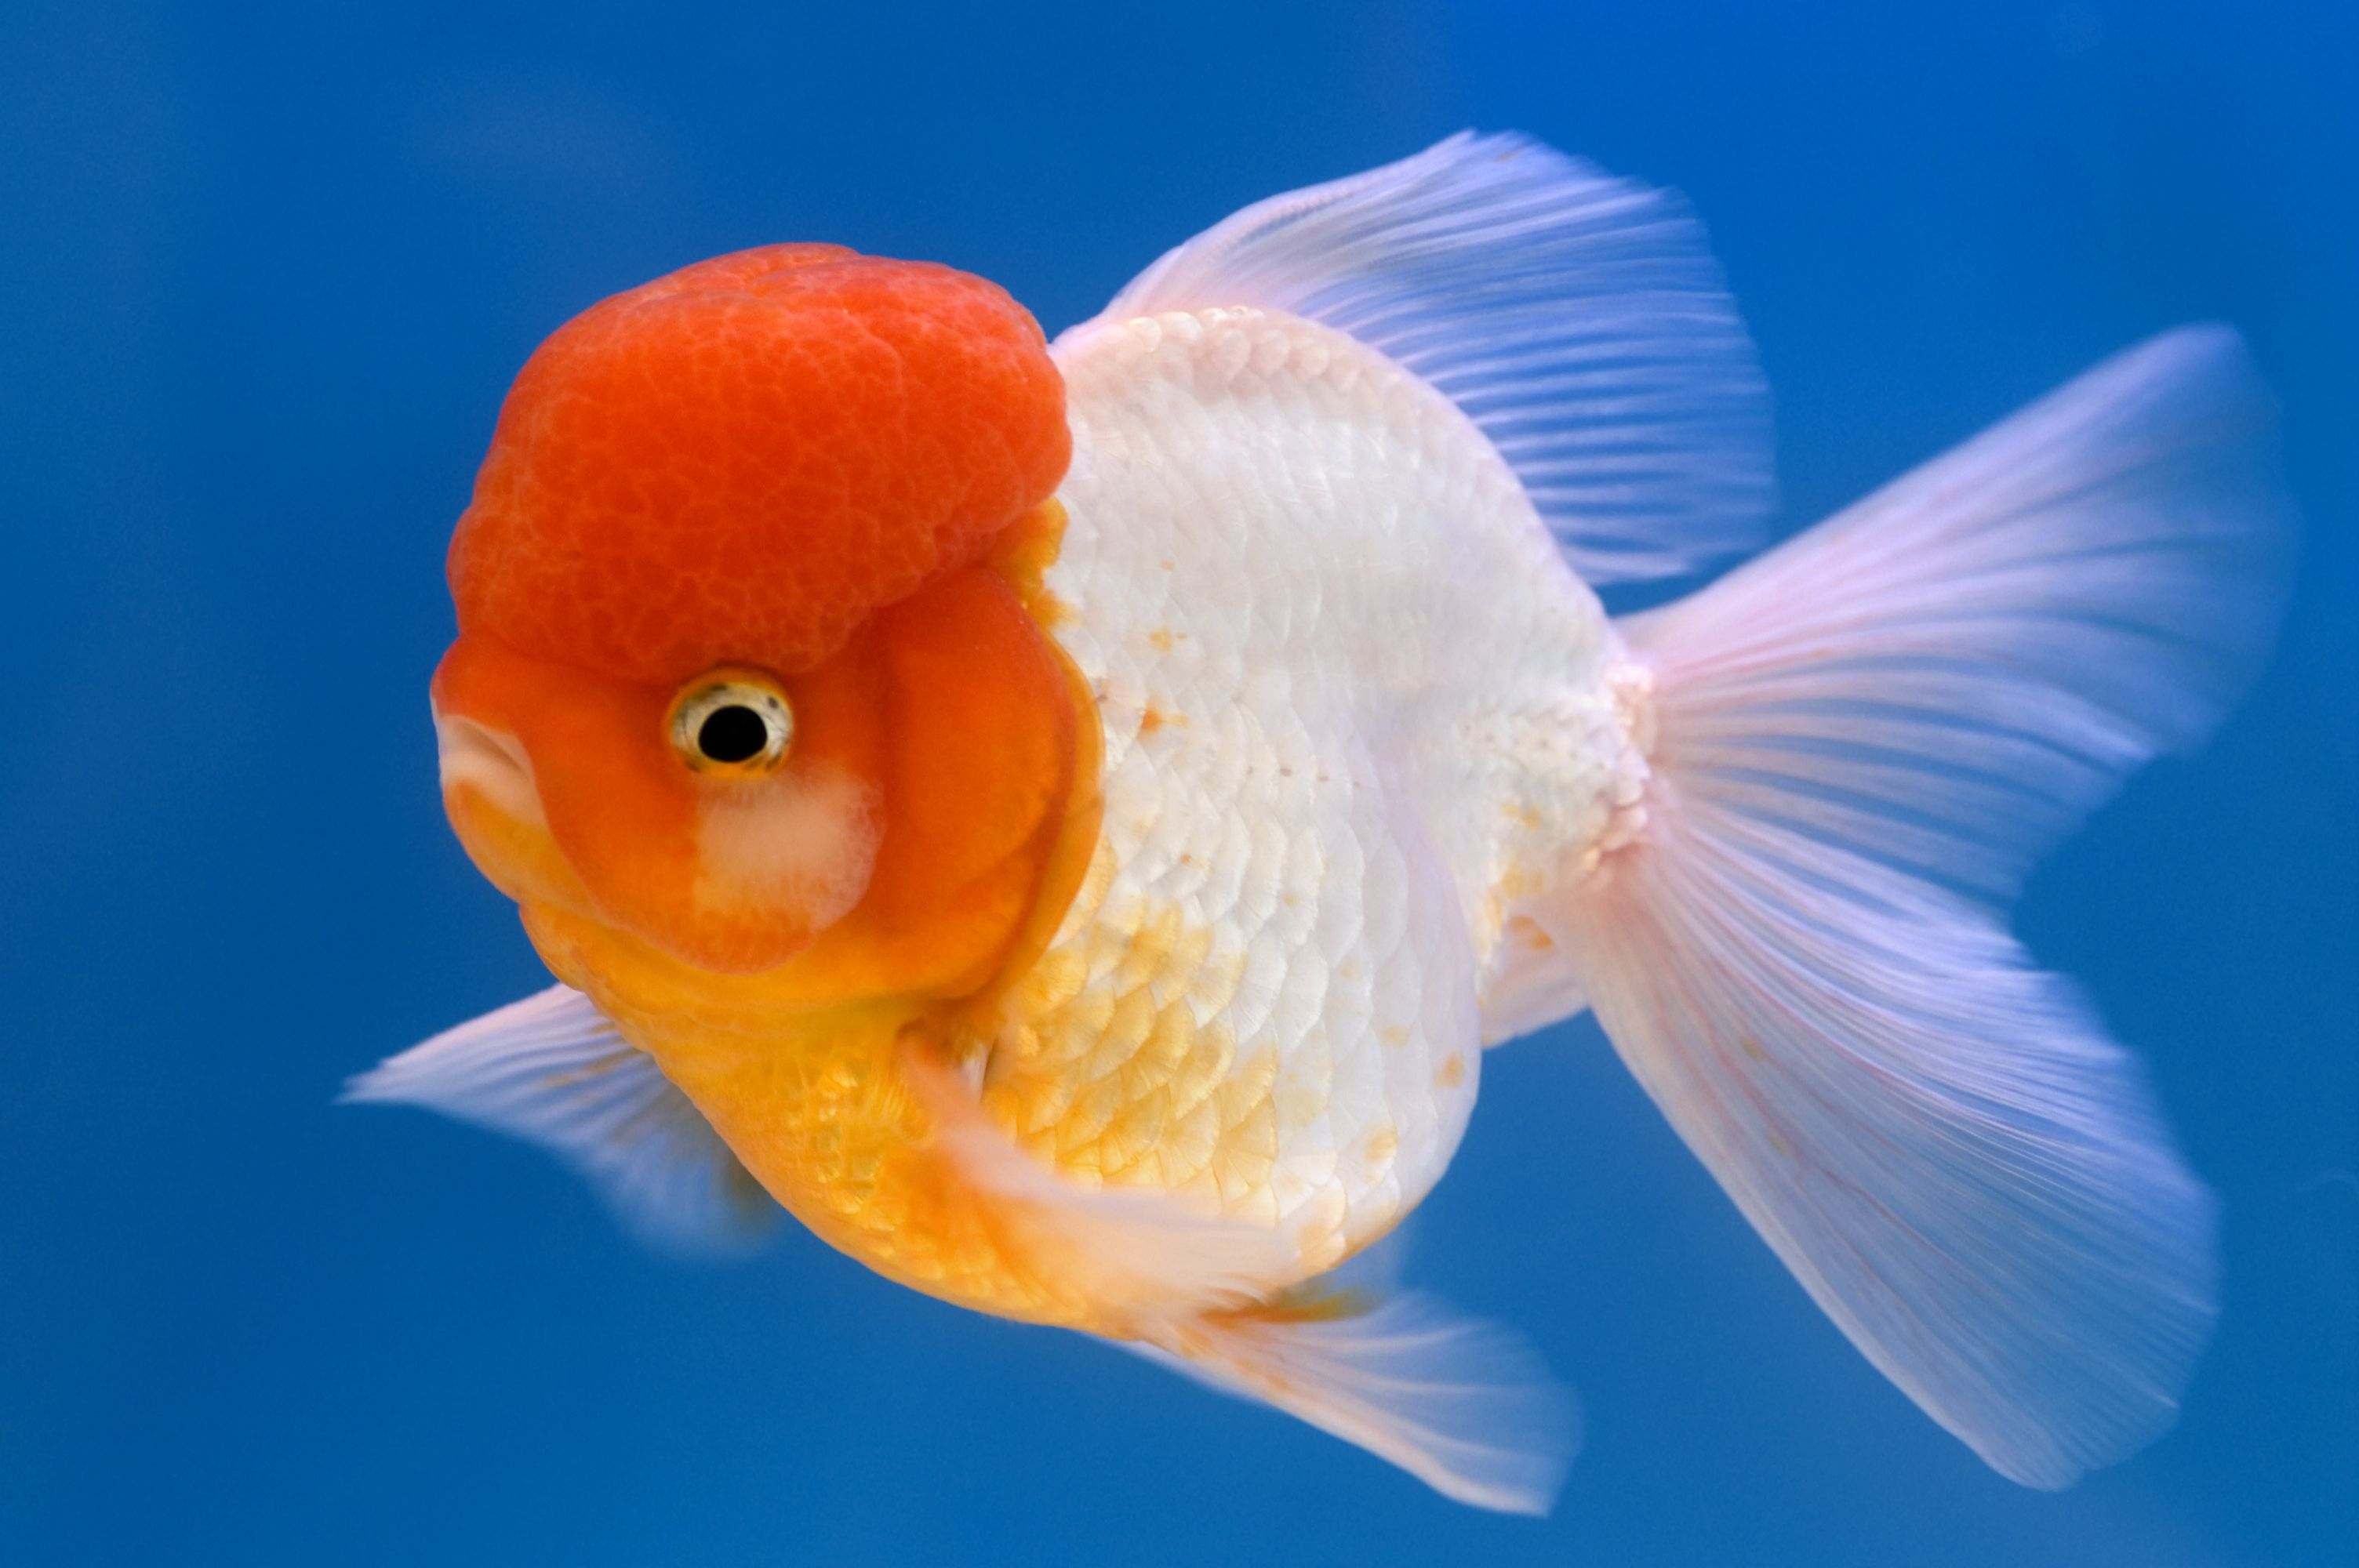

In [51]:
img = 'data/video27/GettyImage.jpg'
PIL.Image.open(img)

In [52]:
# store the resize image
gold_fish = PIL.Image.open(img).resize(IMAGE_SHAPE)

In [53]:
img_bin = np.array(gold_fish)/255.0
img_bin.shape

(224, 224, 3)

In [54]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)), 
    MobileNetv2(),  # Apply custom encoding layer
])
model.build()

In [55]:
predicted = model.predict(img_bin[np.newaxis, ...])
predicted.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


(1, 1001)

In [56]:
predicted_label_index = np.argmax(predicted)
predicted_label_index

2

In [57]:
with open('data/video27/ImageNetLabels.txt') as fp:
    image_labels = fp.readlines()
image_labels = [i.strip() for i in image_labels]
image_labels[predicted_label_index]

'goldfish'

### Using this Google model lets predict flower class

In [12]:
dataset_loc = 'data/video26/datasets/flower_photos'
dataset_loc = pathlib.Path(dataset_loc)
dataset_loc

PosixPath('data/video26/datasets/flower_photos')

In [13]:
# Create a dictonary of all the flowers and lookup name 
flower_images_dict = {}
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_images_dict[dir_name.name] = list(dataset_loc.glob(f'{dir_name.name}/*'))

In [14]:
flower_images_dict.keys()

dict_keys(['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips'])

In [15]:
# create another dictionary with flower name and labels 
flower_labels_dict = {}
count = 0
for dir_name in dataset_loc.iterdir():
    if dir_name.is_dir():
        flower_labels_dict[dir_name.name] = count
        count+=1

flower_labels_dict

{'roses': 0, 'sunflowers': 1, 'daisy': 2, 'dandelion': 3, 'tulips': 4}

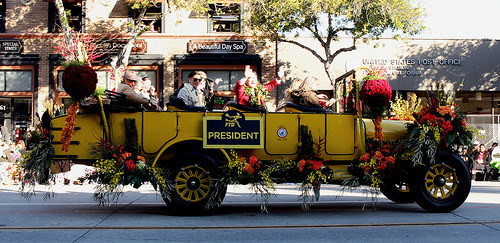

In [16]:
PIL.Image.open(flower_images_dict['roses'][0])

In [17]:
X, y = [], [] 

# loop over the image dictionary 
for flower_name, image_list in flower_images_dict.items():
    for image in image_list:
        img = cv2.imread(image)
        resized = cv2.resize(img, IMAGE_SHAPE)
        X.append(resized)
        y.append(flower_labels_dict.get(flower_name))

In [18]:
def plot_image(X, y, flower_labels_dict, index=0):
    plt.axis('off')
    plt.imshow(X[index])

    if flower_labels_dict:
        label_name = list(flower_labels_dict)[list(flower_labels_dict.values())[y[index]]]
        plt.title(label_name)


In [19]:
# convert the X and y to numpy array 
X = np.array(X)
y = np.array(y)

In [20]:
# perform test train split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [21]:
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0 

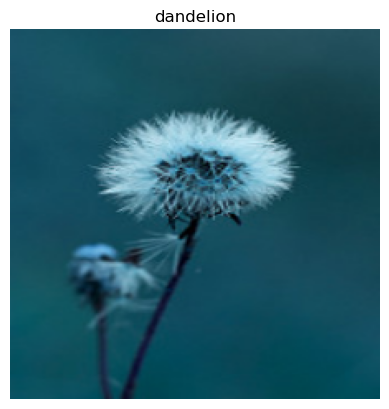

In [22]:
plot_image(X_train, y_train, flower_labels_dict, 0)

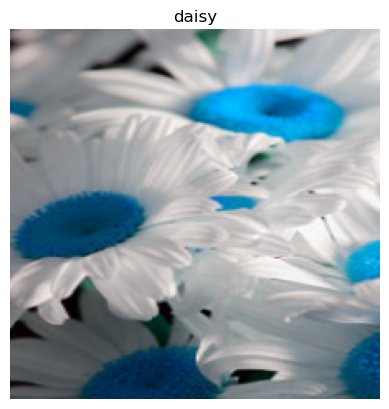

In [23]:
plot_image(X_train, y_train, flower_labels_dict, 1)

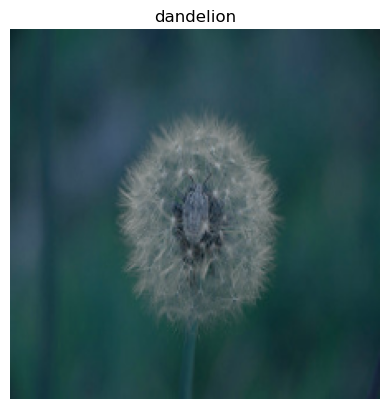

In [24]:
plot_image(X_train, y_train, flower_labels_dict, 2)

In [25]:
predictions = model.predict(np.array([X_train[0], X_train[1], X_train[2]]))
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


array([[ 0.38819313, -1.0133445 ,  2.801355  , ..., -2.1720629 ,
        -0.5283713 ,  1.9418303 ],
       [ 0.30281442,  0.61151433,  1.7873517 , ..., -3.8612416 ,
         1.1618166 ,  2.0723665 ],
       [ 0.15657216, -1.5146961 ,  0.835904  , ..., -1.8904015 ,
        -0.99103254,  1.7784721 ]], dtype=float32)

In [26]:
prediction_class = [np.argmax(i) for i in predictions]
prediction_class

[187, 642, 905]

In [27]:
[image_labels[i] for i in prediction_class]

['Norwich terrier', 'maraca', 'window screen']

```
Let's use feature model with freezed layers

In [28]:
mobilenet_v2_feature_link = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/140-224-feature-vector/2"
mobilenet_v2_feature_layer = hub.KerasLayer(mobilenet_v2_feature_link, 
                                            trainable=False, 
                                            name="mobilenet_v2_feature")

In [29]:
class MobileNetv2Feature(tf.keras.layers.Layer):
    def call(self, inputs):
        return mobilenet_v2_feature_layer(inputs)

In [30]:
# Let's build the model 
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)), 
    MobileNetv2Feature(),  # Apply custom encoding layer
    tf.keras.layers.Dense(5)
])
model.build()

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobile_netv2_feature            │ (None, 1792)           │             0 │
│ (MobileNetv2Feature)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         8,965 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,965 (35.02 KB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer="adam", metrics=["accuracy"])

In [32]:
# train the model 
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.6170 - loss: 0.9959
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.8910 - loss: 0.3309
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9201 - loss: 0.2450
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9500 - loss: 0.1964
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9624 - loss: 0.1508


In [33]:
model.evaluate(X_test_scaled, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9163 - loss: 0.2645


[0.2557506263256073, 0.9172113537788391]

In [34]:
y_pred = model.predict(X_test_scaled)

29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


In [43]:
y_class = [np.argmax(i) for i in y_pred]
y_class[:10]

[0, 1, 2, 3, 3, 1, 2, 2, 4, 0]

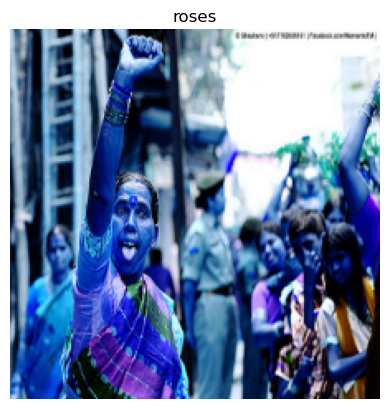

In [44]:
plot_image(X_test, y_test, flower_labels_dict, 0)

In [45]:
list(flower_images_dict.keys())[np.argmax(y_pred[0])]

'roses'